In [69]:
import rebound
import reboundx
import pandas as pd
import numpy as np
from numpy import genfromtxt
import csv
import scipy
from scipy import signal

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

In [20]:
##############
# Read two files that contain orbital parameters for both regular and irregular moons
##############

irreg_data = np.empty((59,10))
with open("irreg_jupiter_data_short.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for i, row in enumerate(reader): # each row is a list
        irreg_data[i,:] = row
        
reg_data = np.empty((8,14))
with open("regular_jupiter_data_short.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for i, row in enumerate(reader): # each row is a list
        reg_data[i,:] = row

radeg = np.pi/180

#############
# Below, we define functions that draw from those files to add moons to the system.
#############

def add_moons(sim, moons):
    for i in range(moons):
        rad = reg_data[i,0]*6.68459e-9
        ecc = reg_data[i,1]
        w = reg_data[i,2]*radeg
        incl = reg_data[i,4]*radeg
        node = reg_data[i,5]*radeg
        mass = reg_data[i,7]/(1.989e30)
        
        sim.add(m=mass, primary=sim.particles[0], a=rad, e=ecc, inc=incl, Omega=w, omega=node)
    return

def add_irregs(sim, moons):
    for i in range(moons):
        rad = irreg_data[i,0]*6.68459e-9
        ecc = irreg_data[i,1]
        w = irreg_data[i,2]*radeg
        incl = irreg_data[i,4]*radeg
        node = irreg_data[i,5]*radeg
        
        sim.add(m=0, primary=sim.particles[0], a=rad, e=ecc, inc=incl, Omega=w, omega=node)
    return

##############
# We also want to play around with some other randomly-generated, massless objects. Below,
# we define functions to add random objects around Jupiter's hill radius and in the L4 Trojan cloud
##############

def add_hillies(sim, num):
    a_rand = np.random.randint(7,9,size=num)
    a_rand = 1/a_rand
    e_rand = np.random.randint(2,10,size=num)
    e_rand = 1/e_rand
    w_rand = np.random.randint(0,360,size=num)*radeg
    half = int(num/2)
    i_rand1 = np.random.randint(0,30,size=half+1)*radeg
    i_rand2 = np.random.randint(150,180,size=half)*radeg
    i_rand = np.concatenate((i_rand1,i_rand2))
    node_rand = np.random.randint(0,360,size=num)*radeg
    
    names = ['hill1', 'hill2', 'hill3', 'hill4']
    
    for i in range(num):
        sem = a_rand[i]
        ecc = e_rand[i]
        icl = i_rand[i]
        Ome = w_rand[i]
        nod = node_rand[i]
        has = 'Hill {0}'.format(i)
        sim.add(m=0, primary=sim.particles['jupiter'], a=sem, e=ecc, inc=icl, Omega=Ome, omega=nod, hash=has)
    return

def add_L4(sim, number):
    a_rand = np.random.normal(20,2,size=number)
    a_rand = a_rand/100 + 5
    e_rand = np.random.normal(9,2,size=number)
    e_rand = e_rand/100
    w_rand = np.random.normal(160,4,size=number)*radeg
    half = int(number/2)
    i_rand1 = np.random.normal(9,4,size=half+1)*radeg
    i_rand2 = np.random.normal(-9,4,size=half)*radeg
    i_rand = np.concatenate((i_rand1,i_rand2))
        
    for i in range(number):
        sem = a_rand[i]
        ecc = e_rand[i]
        icl = i_rand[i]
        Ome = w_rand[i]
        has = 'L4 {0}'.format(i)
        sim.add(m=0, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, Omega=Ome, hash=has)
    return

def add_L5(sim, number):
    a_rand = np.random.normal(20,2,size=number)
    a_rand = a_rand/100 + 5
    e_rand = np.random.normal(9,2,size=number)
    e_rand = e_rand/100
    w_rand = np.random.normal(40,4,size=number)*radeg
    half = int(number/2)
    i_rand1 = np.random.normal(9,4,size=half+1)*radeg
    i_rand2 = np.random.normal(-9,4,size=half)*radeg
    i_rand = np.concatenate((i_rand1,i_rand2))
    
    for i in range(number):
        sem = a_rand[i]
        ecc = e_rand[i]
        icl = i_rand[i]
        Ome = w_rand[i]
        has = 'L5 {0}'.format(i)
        sim.add(m=0, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, Omega=Ome, hash=has)
    return

In [34]:
def masses(x):
    # for input array of time values
    # calculate approximate M_sol
    # at those times in its life
    y = np.zeros_like(x)
    for i, time in enumerate(x):
        if (time <= 1.132e10):
            y[i] = 1
        elif (1.132e10 < time <= 1.1336e10):
            y[i] = 0.05 * (708.5 - time/(1.6e7))**(1/3) + .95
        elif (1.1336e10 < time <= 1.1463e10):
            y[i] =  -8**((time - 1.1463e10)/574511)/2.4 + .95
        elif (1.1463e10 < time):
            y[i] = 0.54
    return y

def lums_array(x):
    y = np.zeros_like(x)
    for i, time in enumerate(x):
        if (time <= 1.113e10):
            y[i] = 1.05
        elif (1.113e10 < time <= 1.1225e10):
            y[i] = 1.45 + ((1.45 - 1.1)/(1.1225e10 - 1.1135e10))*(time - 1.1225e10)
        elif (1.1225e10 < time <= 1.125e10):
            y[i] = 1.45
        elif (1.125 < time <= 1.1336e10):
            y[i] = 1.35 + .1*1.002**((time - 1.125e10)/58000)
        elif (1.1336e10 < time <= 1.142e10):
            y[i] = 1.673
        elif (1.142e10 < time <= 1.14397e10):
            y[i] = 3.198e-9*time - 34.85
        elif (1.14397e10 < time <= 1.14479e10):
            y[i] = 1.736 + 0.032*1.5**((time - 1.14455e10)/360000)
        elif (1.14479e10 < time <= 1.1462e10):
            y[i] = 2.15 + 0.00021*1.5**((time - 1.1444e10)/870000)
        elif (1.1462e10 < time <= 1.14632e10):
            y[i] = 3.5 + (.43/0.0001e10)*(time - 1.1463e10)
        elif (1.14632e10 < time <= 1.14636e10):
            y[i] = 2.3*((time - 1.1463e10)/45000)**(-0.3)
        elif (1.14636e10 < time <= 1.14654715e10):
            y[i] = .2 + ((.2 - 1.05)/(1.14654715e10 - 1.14636e10))*(time - 1.14654715e10)
        elif (1.14654715e10 < time):
            y[i] = .2
    return y        
        
def inst_lum(x):
    time = x
    if (time <= 1.113e10):
        y = 1.05
    elif (1.113e10 < time <= 1.1225e10):
        y = 1.45 + ((1.45 - 1.1)/(1.1225e10 - 1.1135e10))*(time - 1.1225e10)
    elif (1.1225e10 < time <= 1.125e10):
        y = 1.45
    elif (1.125 < time <= 1.1336e10):
        y = 1.35 + .1*1.002**((time - 1.125e10)/58000)
    elif (1.1336e10 < time <= 1.142e10):
        y = 1.673
    elif (1.142e10 < time <= 1.14397e10):
        y = 3.198e-9*time - 34.85
    elif (1.14397e10 < time <= 1.14479e10):
        y = 1.736 + 0.032*1.5**((time - 1.14455e10)/360000)
    elif (1.14479e10 < time <= 1.1462e10):
        y = 2.15 + 0.00021*1.5**((time - 1.1444e10)/870000)
    elif (1.1462e10 < time <= 1.14632e10):
        y = 3.5 + (.43/0.0001e10)*(time - 1.1463e10)
    elif (1.14632e10 < time <= 1.14636e10):
        y = 2.3*((time - 1.1463e10)/45000)**(-0.3)
    elif (1.14636e10 < time <= 1.14654715e10):
        y = .2 + ((.2 - 1.05)/(1.14654715e10 - 1.14636e10))*(time - 1.14654715e10)
    elif (1.14654715e10 < time):
        y = .2
    return y

def yark(simp, rebx_force, particles, N):
    sim = simp.contents
    part = sim.particles
    
    current_time = sim.t + T0
    L_sol = np.exp(inst_lum(current_time))
    
    sim.move_to_hel()
    for troj in range(num_tr):
    
        i = troj + 1
        
        x = part[i].x  ; y = part[i].y  ; z = part[i].z
        vx = part[i].vx; vy = part[i].vy; vz = part[i].vz
        R = part[i].r
        m_ast = troj_masses[i-1]
    
        c = 63197.8 # speed of light in au/yr
        r = np.sqrt(x**2 + y**2 + z**2)
        A = (R**2 * L_sol)/(4*m_ast*r**2)
        D = (c - vx*x - vy*y - vz*z)/r
    
        part[i].ax += A/c**2 * (D*x - vx)
        part[i].ay += A/c**2 * (D*0.25*x + D*y - vx - vy)
        part[i].az += A/c**2 * (D*z - vz)
    return

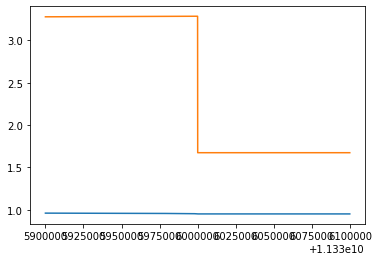

In [35]:
Nout = 10000
T0 = 1.13359e10
times = np.linspace(0, 200000, Nout)
mtimes = masses(times + T0)
lumins = lums_array(times + T0)

plt.plot(times + T0, mtimes)
plt.plot(times + T0, lumins)
plt.show()

# Moon sim

In [7]:
sim = rebound.Simulation()
rhill = 0.3543
radeg = np.pi/180

irrgs_add = 59
moons_add = 0
num_hillies = 6

dt_w_inners = 0.008
dt_no_inner = 0.06

# Add Jupiter and satellites

sim.add(m=9.543e-4, x=0, y=0, z=0, vx=0, vy=0, vz=0, hash='jupiter')
if (moons_add != 0):
    add_moons(sim, moons_add)
if (irrgs_add !=0):
    add_irregs(sim, irrgs_add)
if (num_hillies != 0):
    add_hillies(sim, num_hillies)

# Add Sun as Jupiter-centric; add saturn as solar-centric

sim.add(m=1,primary=sim.particles['jupiter'], a=5.2, e=.04839, inc=-.022689, Omega=-1.8, omega=-.2574, hash='Sun')
sim.add(m=2.8575e-4, primary=sim.particles['Sun'], a=9.537, e=0.05415, inc=0.043284, Omega=1.9844, omega=1.61324, hash='Saturn')

#set simulation parameters

sim.dt = dt_no_inner
sim.ri_ias15.epsilon=0

M0 = sim.particles['Sun'].m
ps = sim.particles

In [8]:
rebx = reboundx.Extras(sim)

gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)

mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

In [24]:
J2 = 14736e-6
J2prime = 0.045020
R_jup = 0.000477895
M_jup = 9.543e-4

ps['jupiter'].params["J2"] = J2prime
ps['jupiter'].params["R_eq"] = R_jup

In [34]:
# initialize arrays for tracking progression of bodies over integration
num = irrgs_add

a_vals = np.zeros((num, Nout))
e_vals = np.zeros((num, Nout))
i_vals = np.zeros((num, Nout))
Omvals = np.zeros((num, Nout))

for moon in range(num):
    if (moons_add == 0):
        a_vals[moon,0] = ps[moon + 1].a
        e_vals[moon,0] = ps[moon + 1].e
        i_vals[moon,0] = ps[moon + 1].inc
        Omvals[moon,0] = ps[moon + 1].pomega
    else:
        a_vals[moon,0] = ps[moon + len(moons_add) + 1].a
        e_vals[moon,0] = ps[moon + len(moons_add) + 1].e
        i_vals[moon,0] = ps[moon + len(moons_add) + 1].inc
        Omvals[moon,0] = ps[moon + len(moons_add) + 1].pomega

mass = np.zeros(Nout)
a_sun = np.zeros(Nout)

In [35]:
for i, time in enumerate(times):
    sim.particles['Sun'].m = masses[i]

    sim.integrate(time)
    a_sun[i] = sim.particles['Sun'].a

    if i == 0:
        fig = rebound.OrbitPlot(sim, figsize=(4,4), color=True, periastron=True)
    if (i+1)%(Nout/4) == 0:
        fig = rebound.OrbitPlot(sim, figsize=(4,4), color=True)
    
    for moon in range(num):
        a_vals[moon, i] = ps[moon + 2].a
        e_vals[moon, i] = ps[moon + 2].e
        i_vals[moon, i] = ps[moon + 2].inc
        Omvals[moon, i] = ps[moon + 2].pomega

TypeError: 'function' object is not subscriptable

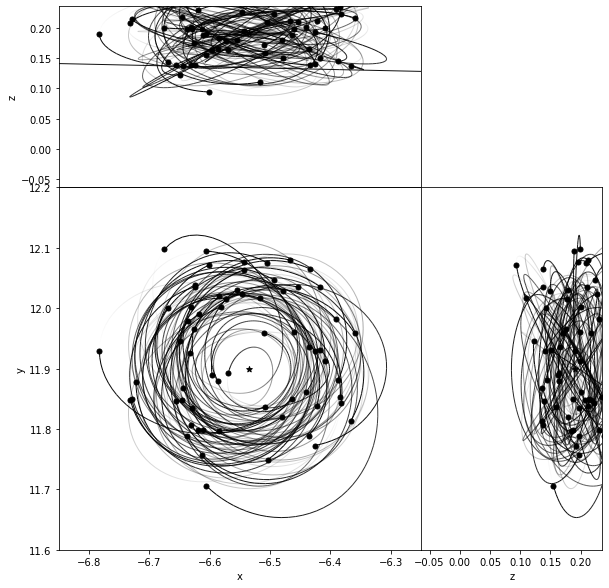

In [155]:
fig = rebound.OrbitPlot(sim, slices=0.5, xlim=[-6.85, -6.25], ylim=[11.6,12.2], figsize=(10,10))

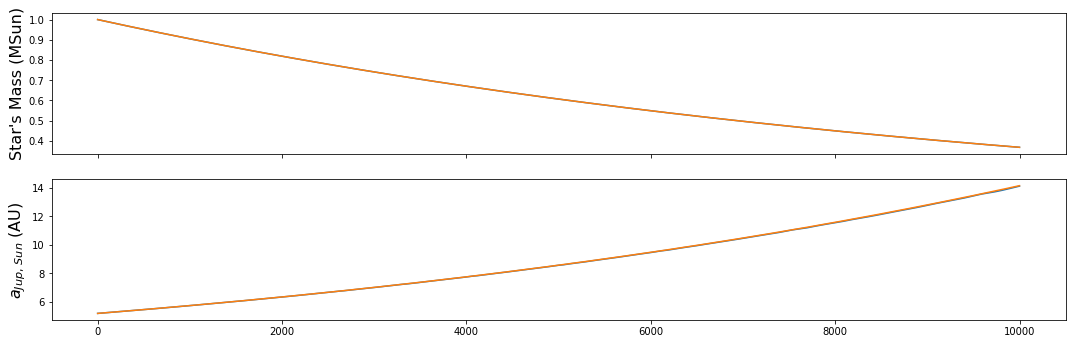

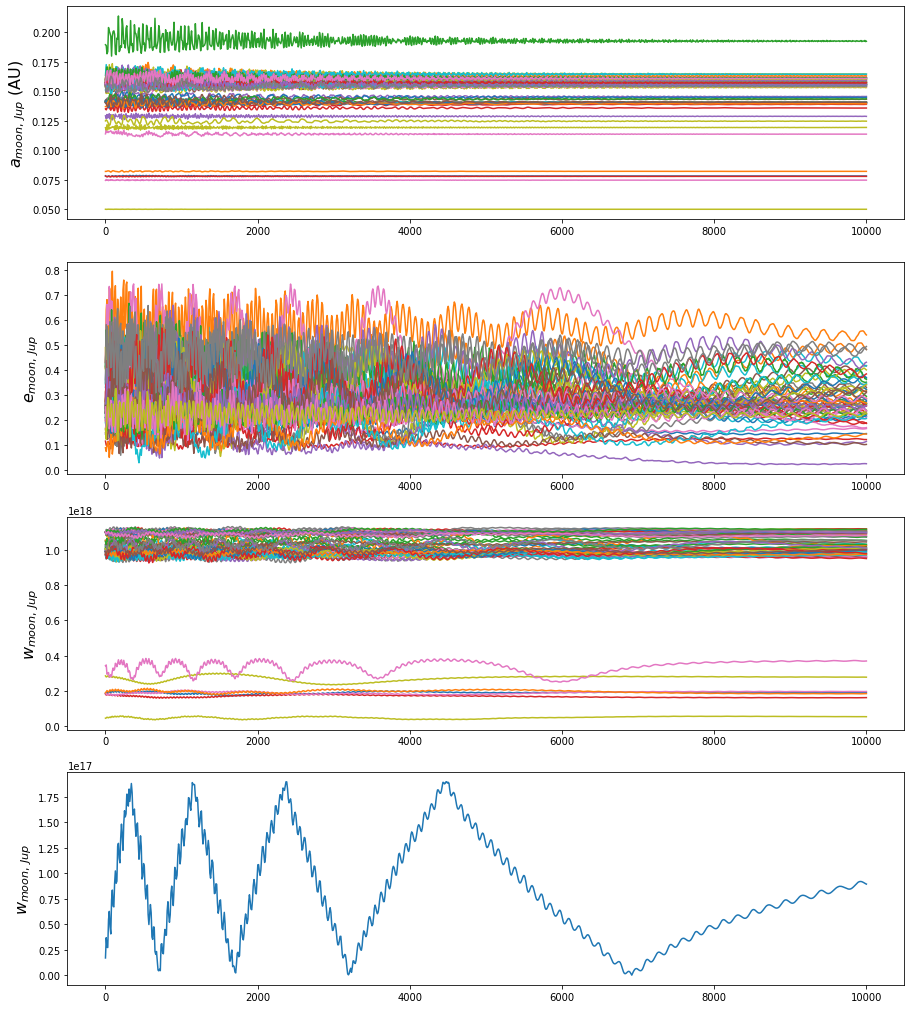

In [164]:
i_vals /= radeg
Omvals /= radeg

pred = M0*np.e**(times/ps['Sun'].params["tau_mass"])
apre = a_sun[0]*np.e**(-times/ps['Sun'].params["tau_mass"])

fig, ax = plt.subplots(2,1,figsize=(15,5), sharex=True)

ax[0].plot(times,mass, label='simulation')
ax[0].plot(times,pred, label='predicted')
ax[0].set_ylabel("Star's Mass (MSun)", fontsize=16)
ax[1].plot(times,a_sun)
ax[1].plot(times,apre)
ax[1].set_ylabel(r"$a_{Jup,\,Sun}$" + " (AU)", fontsize=16)

fig.tight_layout()

trojs, axes = plt.subplots(4,1,figsize=(15,18))

axes[0].plot(times, a_vals.T)
axes[0].set_ylabel(r"$a_{moon,\,Jup}$" + " (AU)", fontsize=16)
axes[1].plot(times, e_vals.T)
axes[1].set_ylabel(r"$e_{moon,\,Jup}$", fontsize=16)
axes[2].plot(times, i_vals.T)
axes[2].set_ylabel(r"$w_{moon,\,Jup}$", fontsize=16)
axes[3].plot(times, Omvals.T[:,5])
axes[3].set_ylabel(r"$w_{moon,\,Jup}$", fontsize=16)

plt.show()

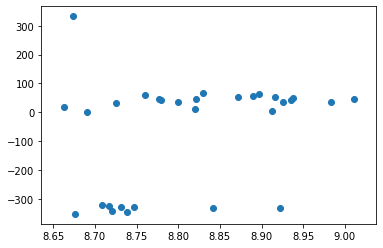

In [35]:
t_top = Nout - 1 #int(t_max - 1)

da = a_vals[:,t_top] - a_vals[:,0]
de = e_vals[:,t_top] - e_vals[:,0]
di = i_vals[:,t_top] - i_vals[:,0]
dw = Omvals[:,t_top] - Omvals[:,0]

plt.scatter(da, dw)
plt.show()

data = [de, de]

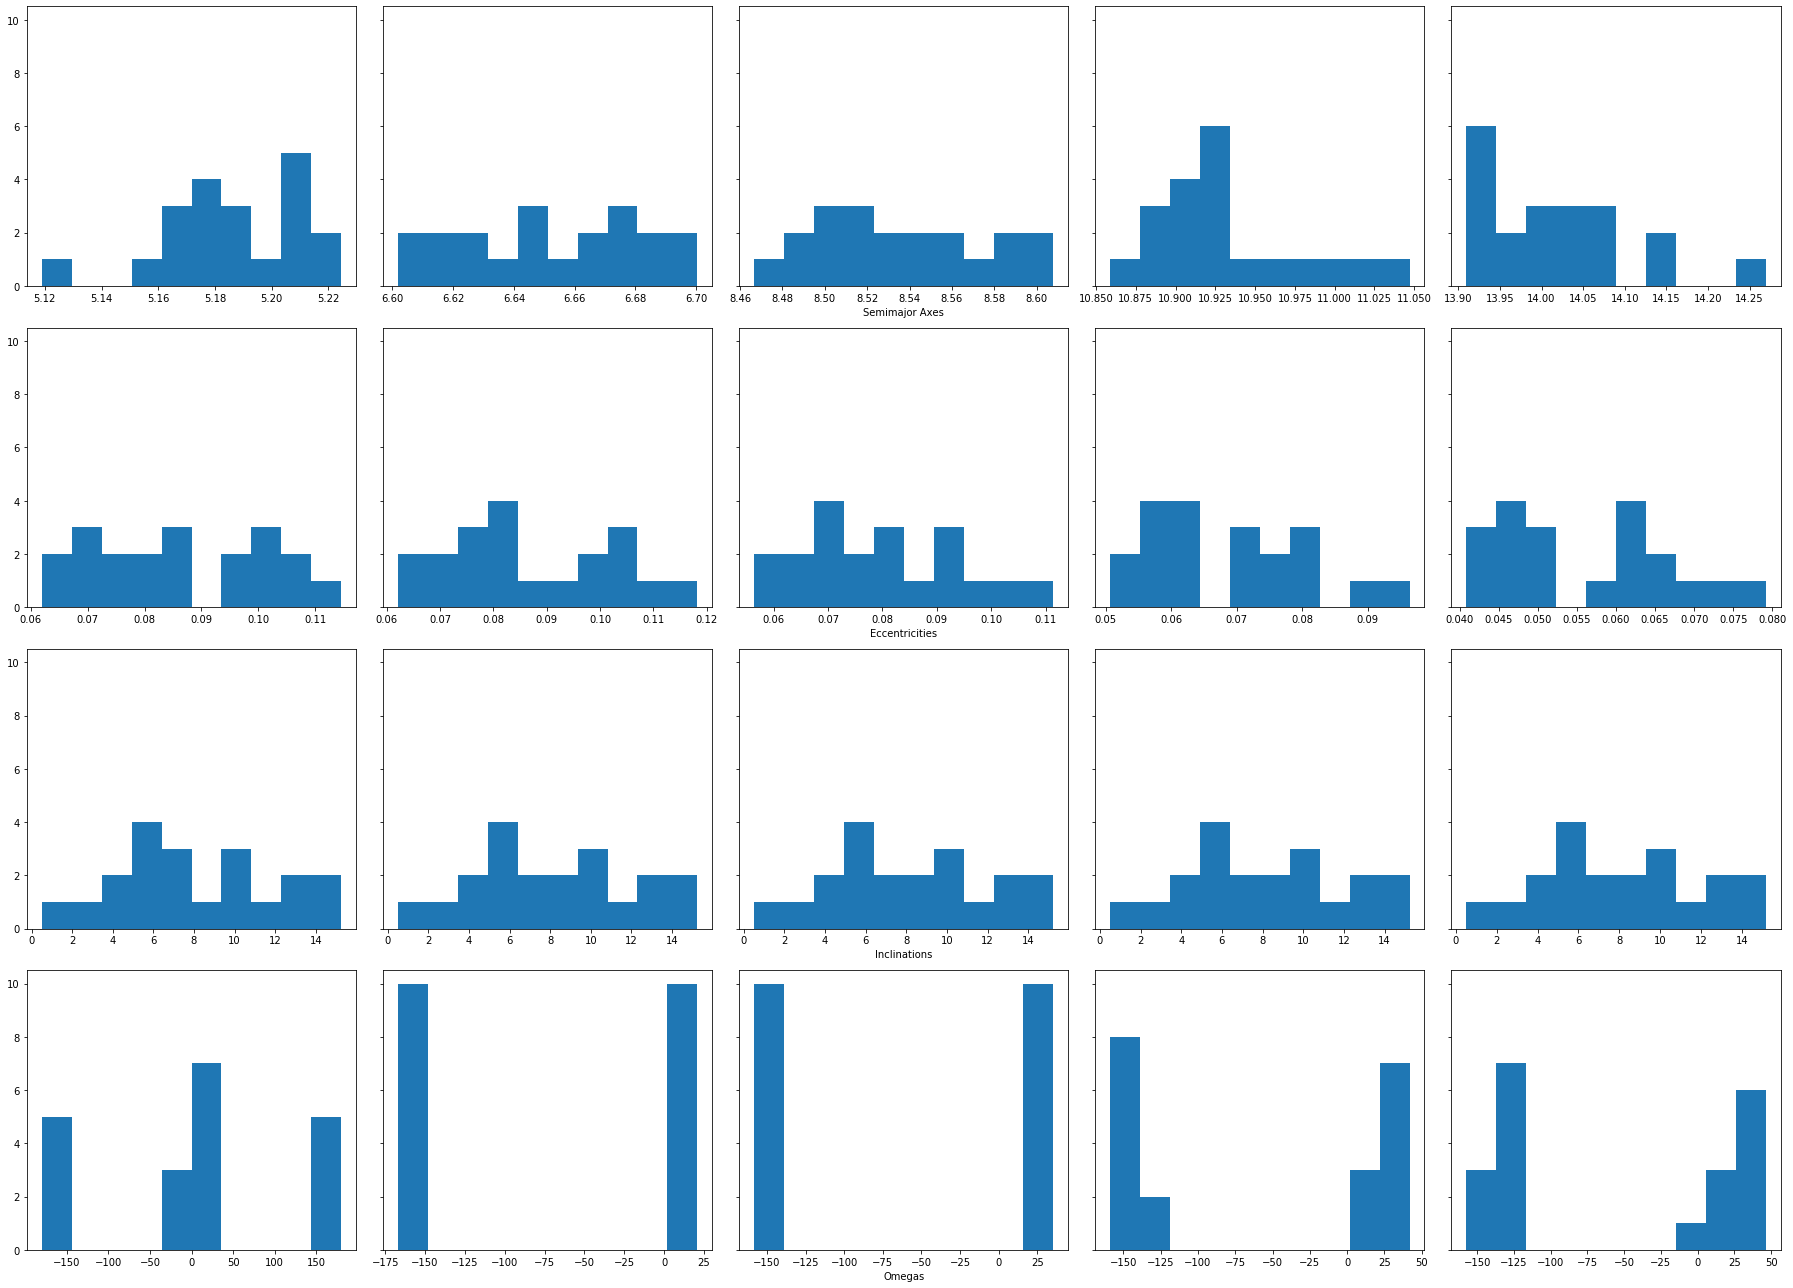

In [21]:
hists, hax = plt.subplots(4,5,figsize=(25,18), sharey=True)

(t1, t2, t3, t4) = (int(Nout/4 - 1), int(Nout/2 - 1), int(3*Nout/4 - 1), int(Nout - 1))

hax[0,0].hist(a_vals[:,0], 10)
hax[0,1].hist(a_vals[:,t1], 10)
hax[0,2].hist(a_vals[:,t2], 10)
hax[0,3].hist(a_vals[:,t3], 10)
hax[0,4].hist(a_vals[:,t4], 10)
hax[0,2].set_xlabel("Semimajor Axes")

hax[1,0].hist(e_vals[:,0], 10)
hax[1,1].hist(e_vals[:,t1], 10)
hax[1,2].hist(e_vals[:,t2], 10)
hax[1,3].hist(e_vals[:,t3], 10)
hax[1,4].hist(e_vals[:,t4], 10)
hax[1,2].set_xlabel("Eccentricities")

hax[2,0].hist(i_vals[:,0], 10)
hax[2,1].hist(i_vals[:,t1], 10)
hax[2,2].hist(i_vals[:,t2], 10)
hax[2,3].hist(i_vals[:,t3], 10)
hax[2,4].hist(i_vals[:,t4], 10)
hax[2,2].set_xlabel("Inclinations")

hax[3,0].hist(Omvals[:,0], 10)
hax[3,1].hist(Omvals[:,t1], 10)
hax[3,2].hist(Omvals[:,t2], 10)
hax[3,3].hist(Omvals[:,t3], 10)
hax[3,4].hist(Omvals[:,t4], 10)
hax[3,2].set_xlabel("Omegas")

hists.tight_layout()

# Trojan analysis

In [157]:
sim = rebound.Simulation()
radeg = np.pi/180
Om_jup = 100.556*radeg
om_jup = 14.753*radeg

num_L4 = 10
num_L5 = 10
num_tr = num_L4 + num_L5

rad_ast = 10 # radius in km
troj_radii = np.full(num_tr, rad_ast/1.496e+8) # gives each asteroid a radius in AU
mass_typic = 3*(4/3)*np.pi*(rad_ast*100000)**3 # gives typical mass @ this radius, w/ density = 3 g cm^-3
print(mass_typic, "g/cm^3")
troj_masses = np.random.normal(mass_typic, .3*mass_typic, num_tr) # gives array of values around that mass
troj_masses /= 1.9891e33 # divides each mass by M_sol to get masses in M_sol
print(np.mean(troj_masses), "M_sol") # average mass in M_sol

# Add sun, trojans, Jupiter, and Saturn

sim.add(m=1,x=0, y=0, z=0, vx=0, vy=0, vz=0, hash='Sun')
add_L4(sim, num_L4)
add_L5(sim, num_L5)
sim.add(m=9.543e-4, a=5.2, e=.04839, inc=.022689, Omega=Om_jup, omega=om_jup, hash='jupiter')
sim.add(m=2.8575e-4, primary=sim.particles['Sun'], a=9.537, e=0.05415, inc=0.043284, Omega=1.9844, omega=1.61324, hash='Saturn')

#set simulation parameters

sim.dt = 0.5

M0 = sim.particles['Sun'].m
ps = sim.particles

1.2566370614359173e+19 g/cm^3
6.180800874815606e-15 M_sol


In [37]:
rebx = reboundx.Extras(sim)

starmass = reboundx.Interpolator(rebx, times, mtimes, 'spline')
starlum = reboundx.Interpolator(rebx, times, lumins, 'spline')

rebx = reboundx.Extras(sim)
yrkv = rebx.create_force("yarkovsky")

yrkv.force_type = "vel"
yrkv.update_accelerations = yark
rebx.add_force(yrkv)

gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)

mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

J2 = 14736e-6
J2prime = 0.045020
R_jup = 0.000477895

ps['jupiter'].params["J2"] = J2prime
ps['jupiter'].params["R_eq"] = R_jup

In [38]:
# initialize arrays for tracking progression of bodies over integration

a_vals = np.zeros((num_tr, Nout))
e_vals = np.zeros((num_tr, Nout))
i_vals = np.zeros((num_tr, Nout))
Omvals = np.zeros((num_tr, Nout))

for moon in range(num_L4):
    a_vals[moon,0] = ps['L4 {0}'.format(moon)].a
    e_vals[moon,0] = ps['L4 {0}'.format(moon)].e
    i_vals[moon,0] = ps['L4 {0}'.format(moon)].inc
    Omvals[moon,0] = ps['L4 {0}'.format(moon)].l
    
for moon in range(num_L5):
    a_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].a
    e_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].e
    i_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].inc
    Omvals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].l

mass = np.zeros(Nout)
a_jup = np.zeros(Nout)

KeyboardInterrupt: 

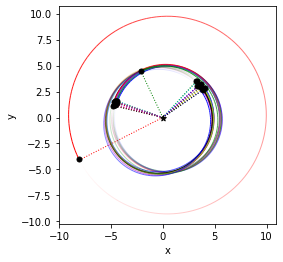

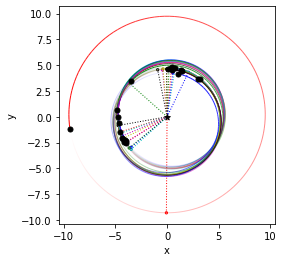

In [39]:
for i, time in enumerate(times):
    sim.integrate(time)
    mass[i] = sim.particles['Sun'].m
    a_jup[i] = sim.particles['jupiter'].a

    if i == 0:
        fig = rebound.OrbitPlot(sim, figsize=(4,4), color=True, periastron=True)
    if (i+1)%(Nout/4) == 0:
        fig = rebound.OrbitPlot(sim, figsize=(4,4), color=True, periastron=True)
    
    for moon in range(num_L4):
        a_vals[moon,i] = ps['L4 {0}'.format(moon)].a
        e_vals[moon,i] = ps['L4 {0}'.format(moon)].e
        i_vals[moon,i] = ps['L4 {0}'.format(moon)].inc
        Omvals[moon,i] = ps['L4 {0}'.format(moon)].l
    
    for moon in range(num_L5):
        a_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].a
        e_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].e
        i_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].inc
        Omvals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].l

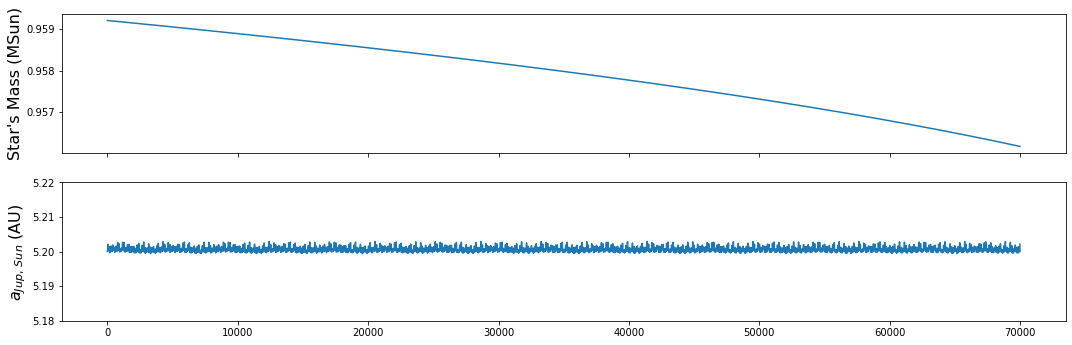

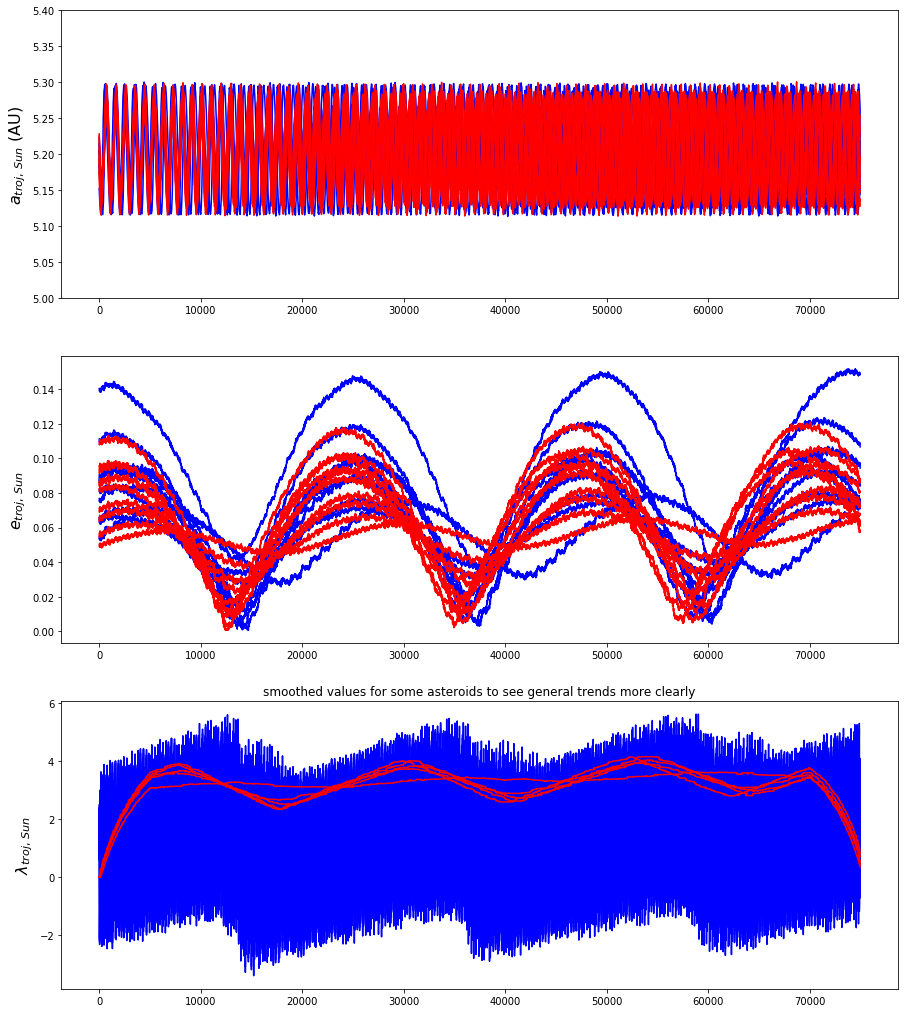

In [159]:
i_vals /= radeg

fig, ax = plt.subplots(2,1,figsize=(15,5), sharex=True)

ax[0].plot(times[:3500],mtimes[:3500], label='simulation')
ax[0].set_ylabel("Star's Mass (MSun)", fontsize=16)
ax[1].plot(times[:3500],a_jup[:3500])
ax[1].set_ylabel(r"$a_{Jup,\,Sun}$" + " (AU)", fontsize=16)
ax[1].set_ylim(5.18,5.22)

fig.tight_layout()

trojs, axes = plt.subplots(3,1,figsize=(15,18))

axes[0].plot(times[:3750], a_vals.T[:3750, num_L4:], 'b')
axes[0].plot(times[:3750], a_vals.T[:3750, :num_L4], 'r')
axes[0].set_ylabel(r"$a_{troj,\,Sun}$" + " (AU)", fontsize=16)
axes[0].set_ylim(5,5.4)
axes[1].plot(times[:3750], e_vals.T[:3750, num_L4:], 'b')
axes[1].plot(times[:3750], e_vals.T[:3750, :num_L4], 'r')
axes[1].set_ylabel(r"$e_{troj,\,Sun}$", fontsize=16)
axes[2].set_title("smoothed values for some asteroids to see general trends more clearly")
axes[2].plot(times[:3750], (Omvals.T[:3750, 10:15]), 'b')
axes[2].plot(times[:3750], signal.medfilt(Omvals.T[:3750, 0:5],[499,1]), 'r')
#axes[2].plot(times, change(Omvals.T)[:,1], 'k', a=3)
axes[2].set_ylabel(r"$\lambda_{troj,\,Sun}$", fontsize=16)

plt.show()

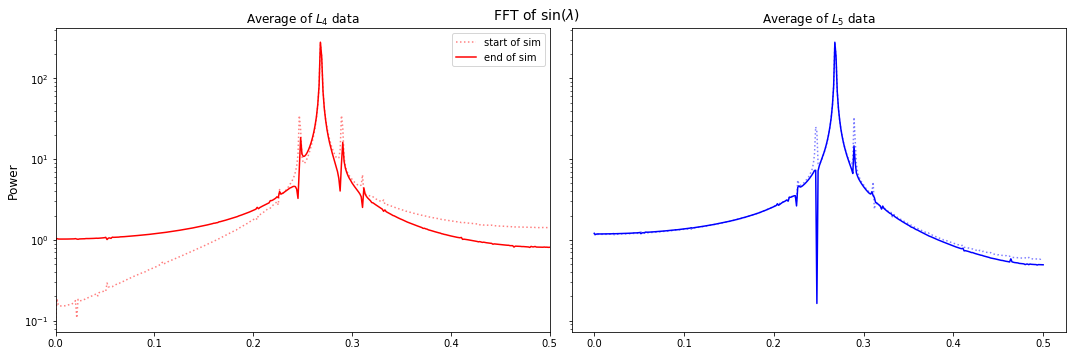

In [153]:
fft_4lambda1 = scipy.fft.rfft(np.sin(Omvals.T[3000:3750,:num_L4]), axis=0)
fft_4lambda2 = scipy.fft.rfft(np.sin(Omvals.T[0:750,:num_L4]), axis=0)
fft_5lambda1 = scipy.fft.rfft(np.sin(Omvals.T[3000:3750,num_L4:]), axis=0)
fft_5lambda2 = scipy.fft.rfft(np.sin(Omvals.T[0:750,num_L4:]), axis=0)
freq = scipy.fft.rfftfreq(times[0:750].shape[-1])

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
ax[0].plot(freq,np.abs(np.mean(fft_4lambda2, axis=1)), c="r", ls=":", alpha=.5)
ax[0].plot(freq,np.abs(np.mean(fft_4lambda1, axis=1)), c="r")
ax[1].plot(freq,np.abs(np.mean(fft_5lambda2, axis=1)), c="b", ls=":", alpha=.5)
ax[1].plot(freq,np.abs(np.mean(fft_5lambda1, axis=1)), c="b")
for i in range(2):
    ax[i].set_yscale("log")
fig.suptitle(r"FFT of sin($\lambda$)", fontsize=14)
ax[0].legend(["start of sim", "end of sim"])
ax[0].set_title(r"Average of $L_4$ data")
ax[1].set_title(r"Average of $L_5$ data")
ax[0].set_xlim(0,.5)
ax[0].set_ylabel("Power", fontsize=12)
fig.tight_layout()
fig.show()

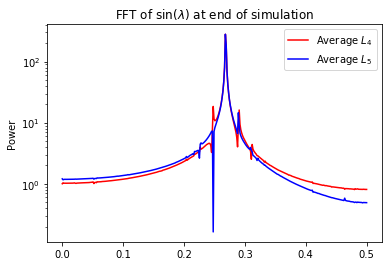

In [156]:
plt.plot(freq,np.abs(np.mean(fft_4lambda1, axis=1)), "r")
plt.plot(freq,np.abs(np.mean(fft_5lambda1, axis=1)), "b")
plt.yscale("log")
plt.ylabel("Power")
plt.legend([r"Average $L_4$",r"Average $L_5$"])
plt.title(r"FFT of sin($\lambda$) at end of simulation")
plt.show()

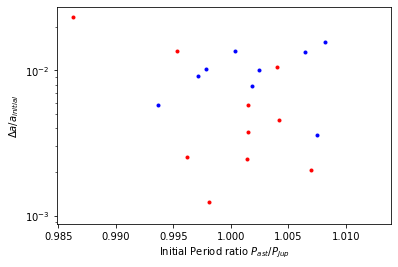

In [160]:
a_inits_L4 = a_vals.T[0,:num_L4]    ; a_inits_L5 = a_vals.T[0,num_L4:]
a_final_L4 = a_vals.T[3750,:num_L4] ; a_final_L5 = a_vals.T[3750,num_L4:]

plt.scatter(np.power(a_inits_L4,1.5)/a_jup[0]**1.5, (np.fabs(a_final_L4-a_inits_L4)+1.0e-16)/a_inits_L4,marker=".",s=36,c="b")
plt.scatter(np.power(a_inits_L5,1.5)/a_jup[0]**1.5, (np.fabs(a_final_L5-a_inits_L5)+1.0e-16)/a_inits_L5,marker=".",s=36,c="r")
plt.xlabel(r"Initial Period ratio $P_{ast}/P_{Jup}$")
plt.ylabel(r"$\Delta a/a_{initial}$")
plt.yscale("log")
plt.show()

Idea for this plot came from https://rebound.readthedocs.io/en/latest/ipython/Testparticles.html -- doesn't look quite as cool as the one there, perhaps I need more particles